# Leer datasets

In [1]:
import pandas as pd
import numpy as np

blob = pd.read_csv('../data/blob_noisy.csv')
blob.head()

,X1,X2,X3,label
0,4.840650,1.030312,0.223647,1
1,4.753778,0.143446,-0.221104,1
2,-2.233238,7.960920,0.770260,0
3,4.614913,1.491620,-0.511961,1
4,5.636037,3.452125,0.045950,1


In [2]:
blob.drop(columns=['label'], inplace=True)

# Realizamos los clusters

In [3]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(blob)
kmeans_labels = kmeans.labels_
dbscan = DBSCAN(eps=1, min_samples=5)
dbscan.fit(blob)
dbscan_labels = dbscan.labels_
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(blob)
gmm_labels = gmm.predict(blob)

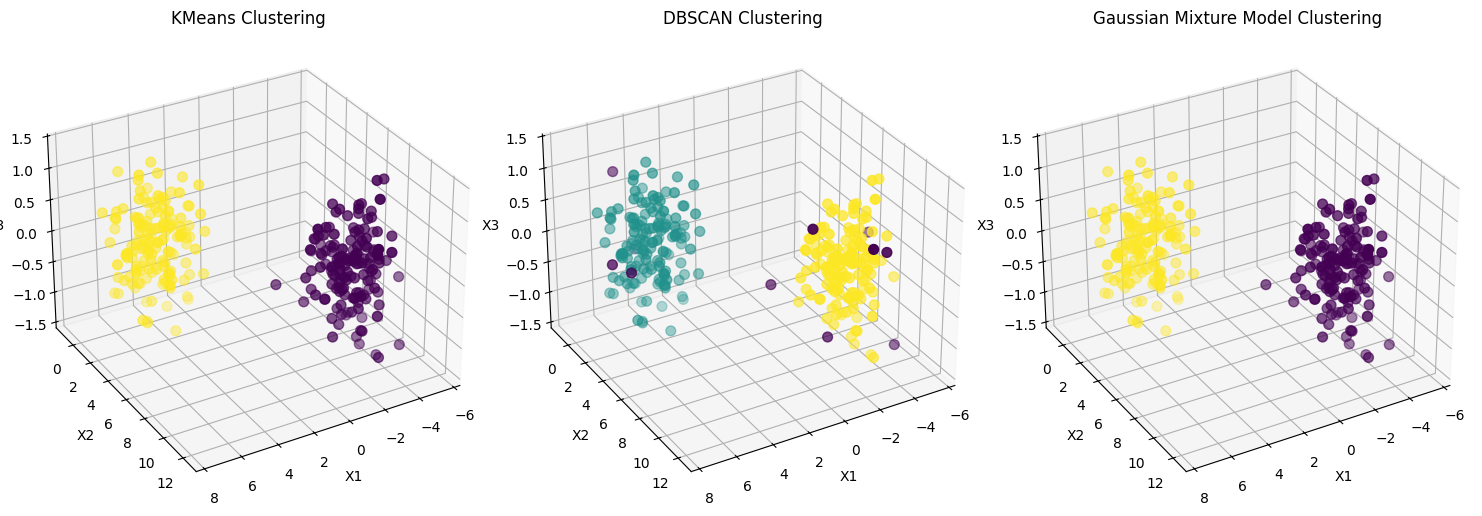

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(blob.iloc[:, 0], blob.iloc[:, 1], blob.iloc[:, 2], c=kmeans_labels, cmap='viridis', s=50)
ax1.set_title('KMeans Clustering')
ax1.set_xlabel(blob.columns[0])
ax1.set_ylabel(blob.columns[1])
ax1.set_zlabel(blob.columns[2])
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(blob.iloc[:, 0], blob.iloc[:, 1], blob.iloc[:, 2], c=dbscan_labels, cmap='viridis', s=50)
ax2.set_title('DBSCAN Clustering')
ax2.set_xlabel(blob.columns[0])
ax2.set_ylabel(blob.columns[1])
ax2.set_zlabel(blob.columns[2])
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(blob.iloc[:, 0], blob.iloc[:, 1], blob.iloc[:, 2], c=gmm_labels, cmap='viridis', s=50)
ax3.set_title('Gaussian Mixture Model Clustering')
ax3.set_xlabel(blob.columns[0])
ax3.set_ylabel(blob.columns[1])
ax3.set_zlabel(blob.columns[2])
ax1.view_init(elev=30, azim=60)
ax2.view_init(elev=30, azim=60)
ax3.view_init(elev=30, azim=60) 
plt.tight_layout()
plt.show()

In [5]:
from sklearn.metrics import silhouette_score
kmeans_silhouette = silhouette_score(blob, kmeans_labels)
dbscan_silhouette = silhouette_score(blob, dbscan_labels)
gmm_silhouette = silhouette_score(blob, gmm_labels)
print(f'KMeans Silhouette Score: {kmeans_silhouette:.2f}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.2f}')
print(f'Gaussian Mixture Model Silhouette Score: {gmm_silhouette:.2f}')

KMeans Silhouette Score: 0.79
DBSCAN Silhouette Score: 0.67
Gaussian Mixture Model Silhouette Score: 0.79


# Interpretar

In [6]:
import sys
sys.path.append('..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

## Kmeans

In [7]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(blob, kmeans_labels, test_size=0.2, random_state=42)


In [36]:
#muestrame los centros de los clusters
centers = kmeans.cluster_centers_
print("KMeans Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

KMeans Cluster Centers:
Cluster 0: [-2.48735777  9.01919485  0.03002731]
Cluster 1: [4.64444668 1.90702967 0.01575304]


In [8]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 1.00


In [9]:
ripper.print_rules()


Reglas para clase: 0
[[X1=-2.82--2.18] V [X1=-2.18--1.77] V [X1=-1.77-0.21] V [X1=<-3.33] V [X1=-3.33--2.82]]

Reglas para clase: 1
[[X2=2.17-2.97] V [X1=3.61-4.3] V [X2=2.97-6.48] V [X2=1.0-1.61] V [X2=1.61-2.17] V [X2=<1.0]]


Decision Tree Accuracy: 1.00


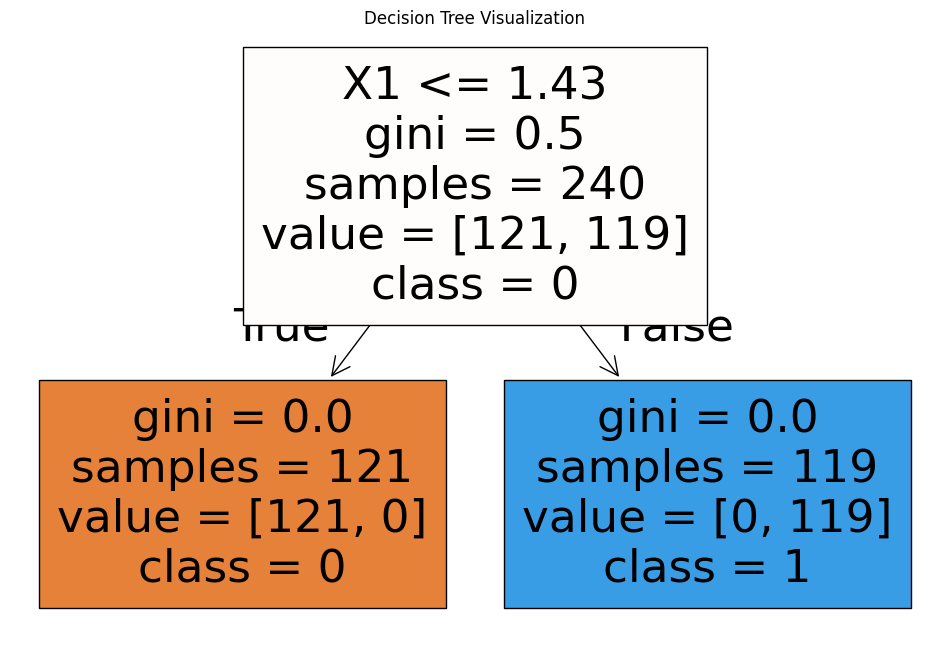

In [10]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [11]:
ds = DSClassifierMultiQ(2, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=blob.columns.tolist())


Optimization started

Training time: 8.03s, epochs: 200

Least training loss reached: 0.009


In [12]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.711] R7: X2 > 7.981
			0: 0.711	1: 0.000	Unc: 0.289

	[0.661] R1: -1.504 < X1 < 1.027
			0: 0.661	1: 0.000	Unc: 0.339

	[0.650] R6: 5.480 < X2 < 7.981
			0: 0.650	1: 0.000	Unc: 0.350

	[0.612] R0: X1 < -1.504
			0: 0.612	1: 0.000	Unc: 0.388

Most important rules for class 1

	[0.717] R3: X1 > 3.558
			0: 0.000	1: 0.717	Unc: 0.283

	[0.672] R2: 1.027 < X1 < 3.558
			0: 0.000	1: 0.672	Unc: 0.328

	[0.670] R4: X2 < 2.979
			0: 0.000	1: 0.670	Unc: 0.330

	[0.610] R5: 2.979 < X2 < 5.480
			0: 0.000	1: 0.610	Unc: 0.390


In [13]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 1.00


## DBSCAN

In [29]:
#dividir los datos en entrenamiento y prueba
n_clusters = len(np.unique(dbscan_labels))
max_label = np.max(dbscan_labels)
dbscan_labels = np.where(dbscan_labels == -1, max_label + 1, dbscan_labels)  # Assign a new label for noise points
X_train, X_test, y_train, y_test = train_test_split(blob, dbscan_labels, test_size=0.2, random_state=42)
print(f'Number of clusters in DBSCAN: {n_clusters}')

Number of clusters in DBSCAN: 3


In [30]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.95


In [31]:
ripper.print_rules()


Reglas para clase: 0
[[X2=2.17-2.97] V [X2=1.61-2.17] V [X2=1.0-1.61] V [X2=<1.0] V [X2=2.97-6.48^X1=4.92-5.65] V [X2=2.97-6.48^X1=4.3-4.92] V [X2=2.97-6.48^X1=3.61-4.3] V [X2=2.97-6.48^X1=0.21-3.61] V [X1=>5.65^X3=-0.17--0.048]]

Reglas para clase: 1
[[X2=8.77-9.24] V [X2=9.24-9.86] V [X2=6.48-8.11] V [X2=8.11-8.77] V [X2=>9.86]]

Reglas para clase: 2
[[X3=>0.67^X2=<1.0] V [X3=0.056-0.16^X1=>5.65^X2=2.97-6.48] V [X1=0.21-3.61^X2=6.48-8.11] V [X1=-3.33--2.82^X3=0.46-0.67]]


Decision Tree Accuracy: 0.95


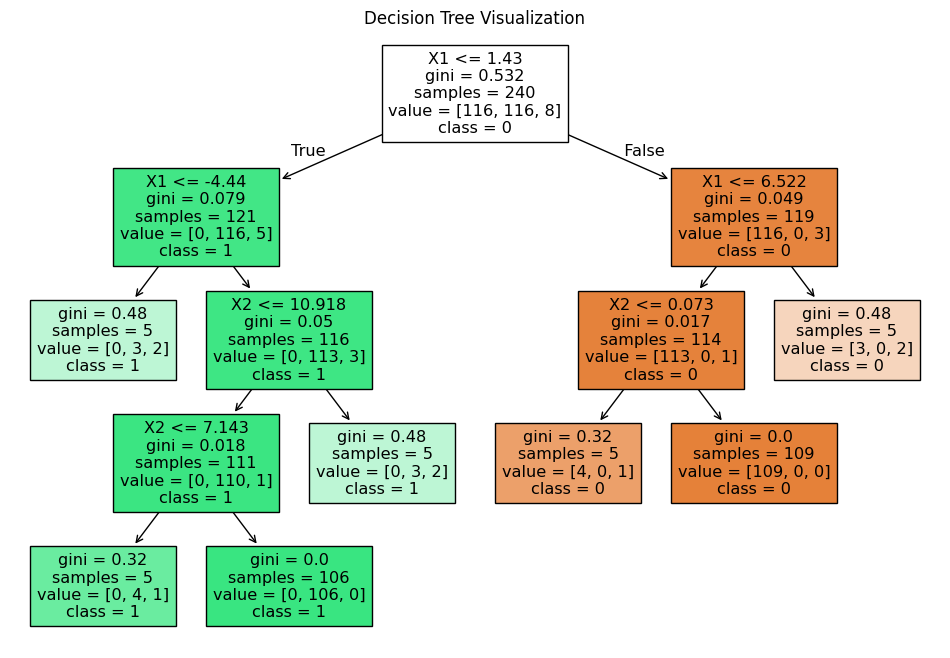

In [32]:
tree = DecisionTreeClassifier(random_state=44, min_samples_leaf=5)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [33]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=blob.columns.tolist())


Optimization started

Training time: 8.50s, epochs: 200

Least training loss reached: 0.027


In [34]:
ds.print_most_important_rules(threshold=0.01)



Most important rules for class 0

	[0.714] R8: X3 < -0.299
			0: 0.538	1: 0.409	2: 0.000	Unc: 0.053

	[0.691] R9: -0.299 < X3 < 0.045
			0: 0.502	1: 0.450	2: 0.000	Unc: 0.048

	[0.691] R3: X1 > 3.558
			0: 0.691	1: 0.000	2: 0.000	Unc: 0.309

	[0.654] R11: X3 > 0.388
			0: 0.498	1: 0.359	2: 0.000	Unc: 0.142

	[0.648] R10: 0.045 < X3 < 0.388
			0: 0.473	1: 0.413	2: 0.000	Unc: 0.114

	[0.610] R2: 1.027 < X1 < 3.558
			0: 0.610	1: 0.000	2: 0.000	Unc: 0.390

	[0.607] R5: 2.979 < X2 < 5.480
			0: 0.593	1: 0.000	2: 0.027	Unc: 0.379

	[0.581] R4: X2 < 2.979
			0: 0.581	1: 0.000	2: 0.000	Unc: 0.419

Most important rules for class 1

	[0.715] R0: X1 < -1.504
			0: 0.000	1: 0.715	2: 0.000	Unc: 0.285

	[0.679] R6: 5.480 < X2 < 7.981
			0: 0.000	1: 0.674	2: 0.012	Unc: 0.315

	[0.659] R7: X2 > 7.981
			0: 0.000	1: 0.659	2: 0.000	Unc: 0.341

	[0.655] R1: -1.504 < X1 < 1.027
			0: 0.000	1: 0.655	2: 0.000	Unc: 0.345

	[0.654] R9: -0.299 < X3 < 0.045
			0: 0.502	1: 0.450	2: 0.000	Unc: 0.048

	[0.622] 

In [35]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.95


## GMM

In [37]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(blob, gmm_labels, test_size=0.2, random_state=42)


In [38]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 1.00


In [39]:
ripper.print_rules()


Reglas para clase: 0
[[X1=-2.82--2.18] V [X1=-2.18--1.77] V [X1=-1.77-0.21] V [X1=<-3.33] V [X1=-3.33--2.82]]

Reglas para clase: 1
[[X2=2.17-2.97] V [X1=3.61-4.3] V [X2=2.97-6.48] V [X2=1.0-1.61] V [X2=1.61-2.17] V [X2=<1.0]]


Decision Tree Accuracy: 1.00


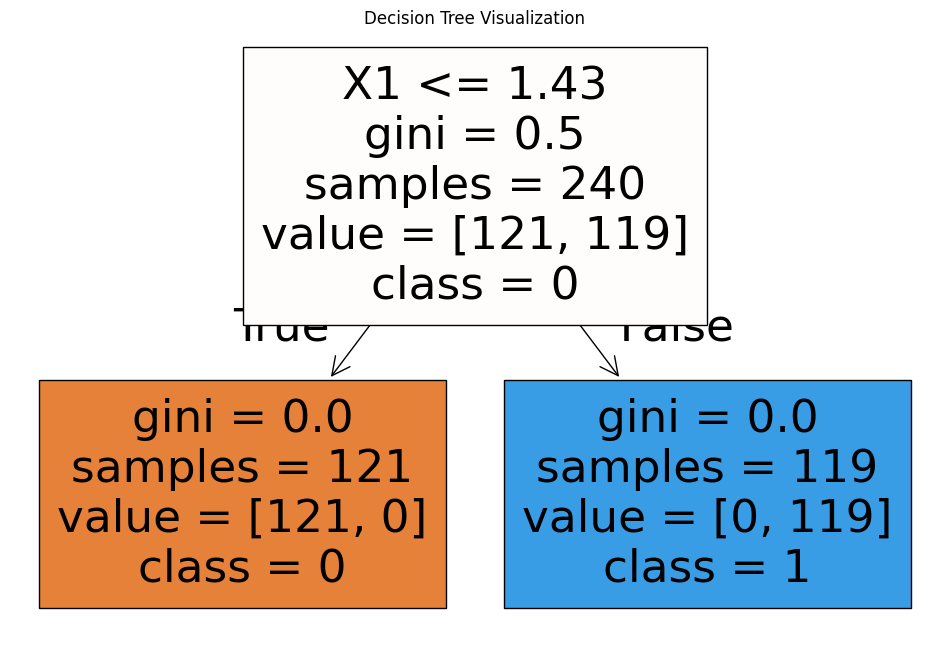

In [40]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [41]:
ds = DSClassifierMultiQ(2, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=blob.columns.tolist())


Optimization started

Training time: 8.28s, epochs: 200

Least training loss reached: 0.012


In [45]:
ds.print_most_important_rules(threshold=0.1)



Most important rules for class 0

	[0.704] R7: X2 > 7.981
			0: 0.704	1: 0.000	Unc: 0.296

	[0.625] R6: 5.480 < X2 < 7.981
			0: 0.625	1: 0.000	Unc: 0.375

	[0.592] R0: X1 < -1.504
			0: 0.592	1: 0.000	Unc: 0.408

	[0.571] R1: -1.504 < X1 < 1.027
			0: 0.571	1: 0.000	Unc: 0.429

	[0.168] R9: -0.299 < X3 < 0.045
			0: 0.152	1: 0.034	Unc: 0.814

	[0.140] R10: 0.045 < X3 < 0.388
			0: 0.107	1: 0.076	Unc: 0.817

	[0.123] R8: X3 < -0.299
			0: 0.085	1: 0.094	Unc: 0.821

	[0.114] R11: X3 > 0.388
			0: 0.070	1: 0.115	Unc: 0.814

Most important rules for class 1

	[0.735] R2: 1.027 < X1 < 3.558
			0: 0.000	1: 0.735	Unc: 0.265

	[0.713] R5: 2.979 < X2 < 5.480
			0: 0.000	1: 0.713	Unc: 0.287

	[0.676] R3: X1 > 3.558
			0: 0.000	1: 0.676	Unc: 0.324

	[0.591] R4: X2 < 2.979
			0: 0.000	1: 0.591	Unc: 0.409

	[0.146] R11: X3 > 0.388
			0: 0.070	1: 0.115	Unc: 0.814

	[0.130] R8: X3 < -0.299
			0: 0.085	1: 0.094	Unc: 0.821

	[0.117] R10: 0.045 < X3 < 0.388
			0: 0.107	1: 0.076	Unc: 0.817


In [43]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 1.00
